In [32]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns 

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from collections import Counter

from cytominer_eval import evaluate
from cytominer_eval.operations import grit
from pycytominer.cyto_utils import infer_cp_features, check_correlation_method 
# from pycytominermodz

# Functions

In [2]:
def load_data(path):
    """
    Loads the csv or csv.gz file into a pandas df, providing unique ID.
    """
    df = pd.read_csv(path)
    
    # Seperate data and metadata
    metadata_cols = [i for i in df.columns if 'Metadata' in i]
    metadata = df[metadata_cols]
    data_cols = [i for i in df.columns if i not in metadata_cols]
    data = df[data_cols]
    
    # Use metadata to create the index
    metadata_df = metadata.copy()
    data_df = data.copy()
    metadata_df['my_id'] = metadata['Metadata_line_source'] + '_' + metadata['Metadata_line_condition'] + '_' + \
        metadata['Metadata_line_ID'].astype(str) + '_' + metadata['Metadata_well_position']
    data_df['my_id'] = metadata_df['my_id']
    data_df.set_index('my_id', inplace=True)
    print('df shape: {}'.format(data_df.shape))
    
#     Remove the extraneous 'control' or 'deletion' for the isogenic perturbs, to keep naming consistency.
    new_idx = data_df.index.tolist()
    new_idx = [i.split('_')[0]+'_'+ i.split('_')[1]+'_'+ i.split('_')[3]+'_' +i.split('_')[4] \
               if 'genic' in i else i for i in new_idx]
    
    data_df.index = new_idx
    return data_df

def unstack_formatted_matrix(df, double=False):
    """
    df: a matrix which was the result of get_formatted_matrix
    double: whether to replicate the df and append, with id1 and id2 reversed. That way, all perturbs are represented in
        each id column, making finding non-group correlations easier
    returns: unstacked version of the matrix
    """
    
    # Unstacks the df and gets pairwise correlations for every perturbation instance
    unstack_agg_features_all = df.T.copy()
    unstack_agg_features_all = unstack_agg_features_all.corr(method='spearman')
    unstack_agg_features_all_tophalf = unstack_agg_features_all.where(np.triu(np.ones(unstack_agg_features_all.shape)).astype(np.bool))

    unstack_agg_all = unstack_agg_features_all_tophalf.unstack().reset_index()
    unstack_corrs_agg = unstack_agg_all.rename(columns={"level_0": "id1", "level_1": "id2", 0: "correlation"})
    # At this point, should be (384+383+...+3+2+1) = 73920 rows
    unstack_corrs_agg = unstack_corrs_agg[~unstack_corrs_agg['correlation'].isna()]
     
    # Replicate and append the dataframe, if double is True, so that each perturb is present in both cols. 
    # Should have 73920*2 cols.
    if double:
        repl = unstack_corrs_agg.copy()
        temp_id1 = repl['id1'].tolist()
        temp_id2 = repl['id2'].tolist()
        repl['id1'] = temp_id2
        repl['id2'] = temp_id1
        unstack_corrs_agg = unstack_corrs_agg.append(repl)

    # Remove correlations where id1 == id2 (same well), should have 73536(*2) rows
    unstack_corrs_agg = unstack_corrs_agg[unstack_corrs_agg['id1'] != unstack_corrs_agg['id2']]
    unstack_corrs_agg.reset_index(inplace=True, drop=True)     
    
    # Add columns to label unique perturbs
    unstack_corrs_agg['perturb1'] = unstack_corrs_agg['id1'].str.split('_').map(lambda x: x[0] + '_' + x[1])
    unstack_corrs_agg['perturb2'] = unstack_corrs_agg['id2'].str.split('_').map(lambda x: x[0] + '_' + x[1])
    unstack_corrs_agg['cell_line1'] = unstack_corrs_agg['id1'].str.split('_').map(lambda x: x[0] + '_' + x[1] + '_' + x[2])
    unstack_corrs_agg['cell_line2'] = unstack_corrs_agg['id2'].str.split('_').map(lambda x: x[0] + '_' + x[1] + '_' + x[2])
    return unstack_corrs_agg 

In [3]:
def hierarchical_cluster(df, threshold, show=False):
    """
    Returns df of cluster features
    """
    threshold=threshold
    Z1 = linkage(df, 'ward')
    flat_linkage1 = fcluster(Z1, t=threshold, criterion='distance')
    cluster_features1 = id_to_cluster(flat_linkage1, df)
    
    if show:
        plt.figure(figsize=(12, df.shape[0]/4))
        plt.axvline(x=threshold)
        label = [str(i) + ' ' + j for i, j in zip(flat_linkage1.tolist(), df.index.tolist())]
        plt.title('Clusters based on cell profiler features')
        dend1 = dendrogram(Z1, color_threshold=threshold, orientation='left', leaf_font_size=10, labels=label)
    return cluster_features1

def id_to_cluster(linkage_data, agg_features_df):
    """
    linkage_data: array of cluster numbers
    agg_features_df: df of aggregated features to merge, index must match order of linkage_data
    Returns a df with aggregated cp data and cluster number for each id
    """
    # Get cluster number with the aggregated feature data
    clusters_hierarchal_df = pd.DataFrame(data=linkage_data, index=agg_features_df.index)
    clusters_hierarchal_df.rename(columns={0:'cluster_num'}, inplace=True)
    clusters_hierarchal_df = clusters_hierarchal_df.merge(agg_features_df, how='left', left_index=True, right_index=True)

    # Get the cell profiler features by cluster
    cp_features_by_cluster = clusters_hierarchal_df.groupby(by='cluster_num').mean()
    
    return clusters_hierarchal_df

In [18]:
def ttest_2_df(df1, df2, alpha=0.05, reject_only=True):
    """
    Inputs are 2 dataframes with the same column features. Returns FDR adjusted p-values for each feature.
    """
#     assert df1.columns == df2.columns
    z_score, pvals = ttest_ind(df1.values, df2.values, axis=0)
    p_df = pd.DataFrame(pvals, index = df1.columns)
    p_df = p_df.rename(columns={0: 'pval'}) # unadjusted p values
    
    # Remove first row, which is just a ttest on the column number
    p_df =  p_df.iloc[1:]
    
    # Get corrected p-values
    q_df = p_df
    q_df['adj_p_value'] = multipletests(p_df['pval'].values, alpha=alpha, method='fdr_bh')[1]
    q_df['reject_null'] = multipletests(p_df['pval'].values, alpha=alpha, method='fdr_bh')[0]
    
    if reject_only:
        q_df = q_df[q_df['reject_null'] == True]
    
    return q_df

In [4]:
# Normalized var selected data, provided to me 
data_by_well = load_data('C:/Users/Ruifan/neuronal-cell-painting/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized_variable_selected.csv.gz')

df shape: (384, 414)


# Feature Landscape

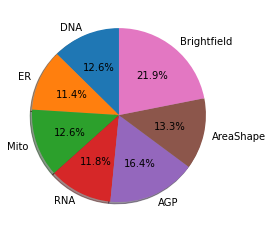

[60, 54, 60, 56, 78, 63, 104] 475


In [51]:
# Features by image channel
all_features = data_by_well.columns.tolist()
dna_ch = [i for i in all_features if 'DNA' in i[-20:]]
er_ch = [i for i in all_features if 'ER' in i[-20:]]
mito_ch = [i for i in all_features if 'Mito' in i[-20:]]
rna_ch = [i for i in all_features if 'RNA' in i[-20:]]
agp_ch = [i for i in all_features if 'AGP' in i[-20:]]
areashape = [i for i in all_features if 'AreaShape' in i]
brightfield = [i for i in all_features if 'Brightfield' in i]
labels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'AreaShape', 'Brightfield']
sizes = [len(dna_ch), len(er_ch), len(mito_ch), len(rna_ch), len(agp_ch), len(areashape), len(brightfield)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

print(sizes,sum(sizes))

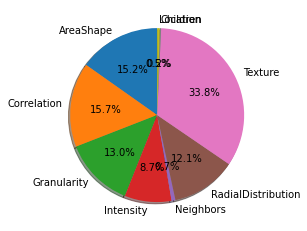

[63, 65, 54, 36, 3, 50, 140, 1, 2] 414


In [55]:
# Features by feature type
all_features = data_by_well.columns.tolist()
all_feature_types = [i.split('_')[1] for i in all_features]
all_feature_types = Counter(all_feature_types)
labels = []
sizes = []

fig1, ax1 = plt.subplots()
for x,y in all_feature_types.items():
    labels.append(x)
    sizes.append(y)

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()
print(sizes,sum(sizes))


In [40]:
all_features

['Cells_AreaShape_Center_X',
 'Cells_AreaShape_Eccentricity',
 'Cells_AreaShape_MedianRadius',
 'Cells_AreaShape_Zernike_2_0',
 'Cells_AreaShape_Zernike_3_1',
 'Cells_AreaShape_Zernike_4_0',
 'Cells_AreaShape_Zernike_4_2',
 'Cells_AreaShape_Zernike_5_1',
 'Cells_AreaShape_Zernike_5_3',
 'Cells_AreaShape_Zernike_6_0',
 'Cells_AreaShape_Zernike_6_2',
 'Cells_AreaShape_Zernike_6_4',
 'Cells_AreaShape_Zernike_7_1',
 'Cells_AreaShape_Zernike_7_3',
 'Cells_AreaShape_Zernike_7_5',
 'Cells_AreaShape_Zernike_8_0',
 'Cells_AreaShape_Zernike_8_2',
 'Cells_AreaShape_Zernike_8_4',
 'Cells_AreaShape_Zernike_8_6',
 'Cells_AreaShape_Zernike_8_8',
 'Cells_AreaShape_Zernike_9_1',
 'Cells_AreaShape_Zernike_9_3',
 'Cells_AreaShape_Zernike_9_5',
 'Cells_AreaShape_Zernike_9_7',
 'Cells_Correlation_Correlation_DNA_ER',
 'Cells_Correlation_Correlation_DNA_Mito',
 'Cells_Correlation_Correlation_DNA_RNA',
 'Cells_Correlation_Correlation_ER_AGP',
 'Cells_Correlation_Correlation_Mito_AGP',
 'Cells_Correlation_Cor

# Correlations

<ipython-input-5-756bd5acccd6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


0.538374056245705


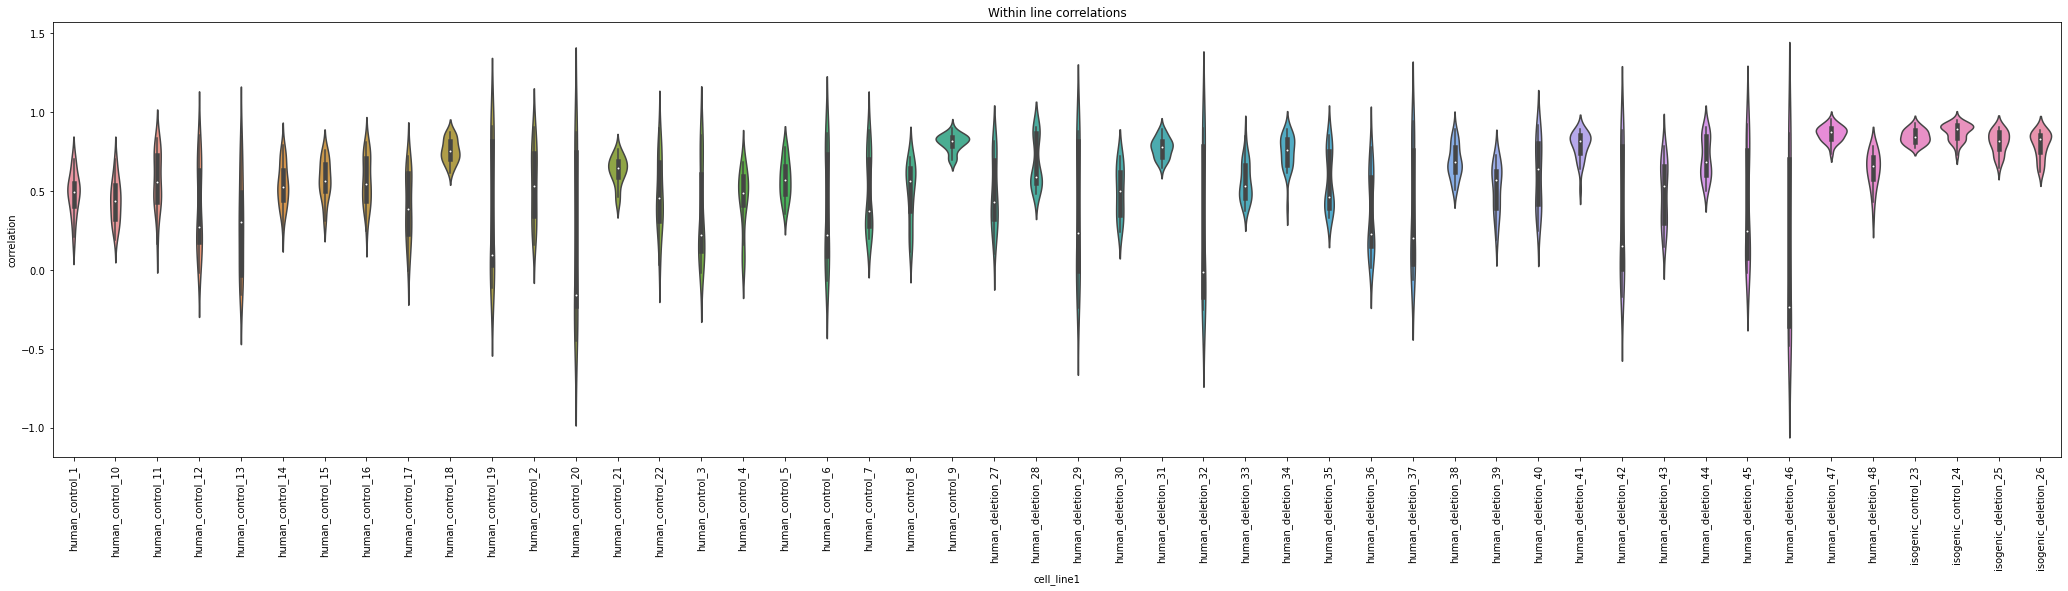

In [5]:
corrs = unstack_formatted_matrix(data_by_well)

# Get correlations within each cell line (8 replicates per)
corrs_within_line = corrs[corrs['cell_line1']==corrs['cell_line2']]

# Plot the self correlations
order = sorted(list(set(corrs_within_line['cell_line1'].tolist())))
fig, ax = plt.subplots(figsize=(36,8))
plt.title('Within line correlations')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax = sns.violinplot(x='cell_line1', y='correlation', data=corrs_within_line, order=order)

print(corrs_within_line['correlation'].mean())

<ipython-input-6-d894ad4784e7>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


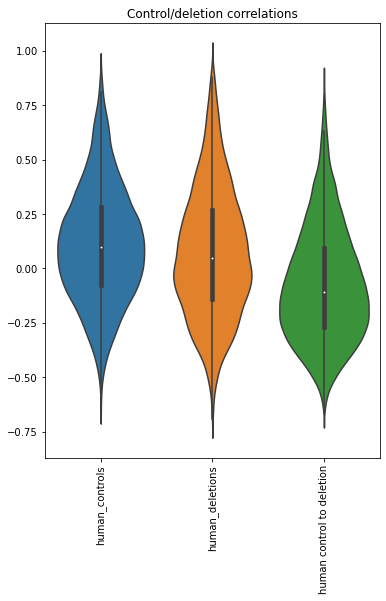

In [6]:
# Correlations between human controls, human deletion, and controls to deletion
corr_controls = corrs[(corrs['perturb1'] == 'human_control') & (corrs['perturb2'] == 'human_control')]
corr_deletion = corrs[(corrs['perturb1'] == 'human_deletion') & (corrs['perturb2'] == 'human_deletion')]
corr_control_to_deletion = corrs[(corrs['perturb1'] == 'human_deletion') & (corrs['perturb2'] == 'human_control') 
                                 | (corrs['perturb1'] == 'human_control') & (corrs['perturb2'] == 'human_deletion')]

to_df = [corr_controls['correlation'].tolist(), corr_deletion['correlation'].tolist(), corr_control_to_deletion['correlation'].tolist()]
corrs_controls_deletions = pd.DataFrame(to_df, index=['human_controls', 'human_deletions', 'human control to deletion']).T

# Plot the control/deletion correlations
fig, ax = plt.subplots(figsize=(6,8))
plt.title('Control/deletion correlations')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax = sns.violinplot(data=corrs_controls_deletions)

# Clusters

In [7]:
data_by_line = data_by_well.copy()
data_by_line['split'] = data_by_line.index.str.split('_')
data_by_line['perturb'] = [i[0] + '_' + i[1] + '_' + i[2] for i in data_by_line['split']]
data_by_line = data_by_line.groupby(by='perturb').median()

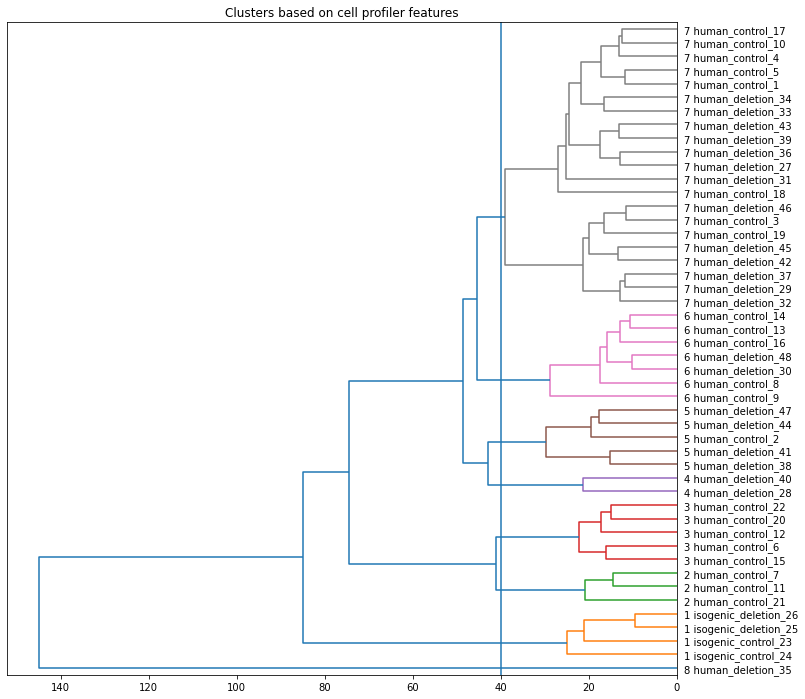

In [8]:
clusters1 = hierarchical_cluster(data_by_line, 40, show=True)

# PCA

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

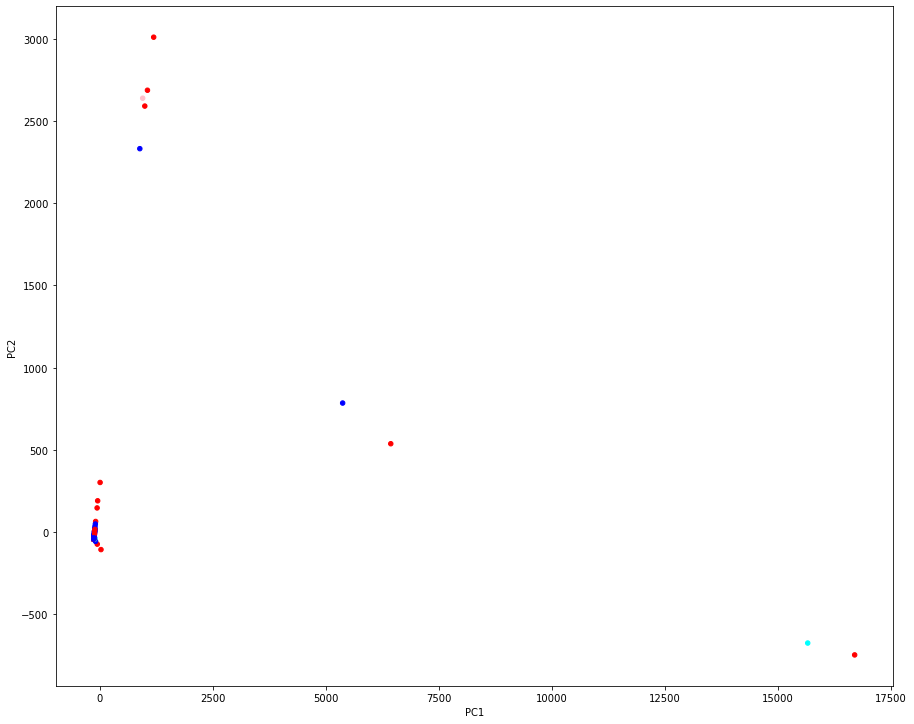

In [9]:
pca = PCA(n_components=2)
pca_fit = pca.fit(data_by_well)
pca_vals = pca_fit.transform(data_by_well)
pca_df = pd.DataFrame(pca_vals, columns=['PC1', 'PC2'], index=data_by_well.index)
idxs = [i.split('_')[0] + '_' + i.split('_')[1] for i in pca_df.index.tolist()]
idx2color = {'human_control': 'b', 'isogenic_control': 'cyan', 'human_deletion': 'r', 'isogenic_deletion': 'pink'}
colors = [idx2color[i] for i in idxs]
pca_df['color'] = colors

fig, ax = plt.subplots(figsize=(15,12.5))
pca_df.plot('PC1', 'PC2', kind='scatter', ax=ax, c='color')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

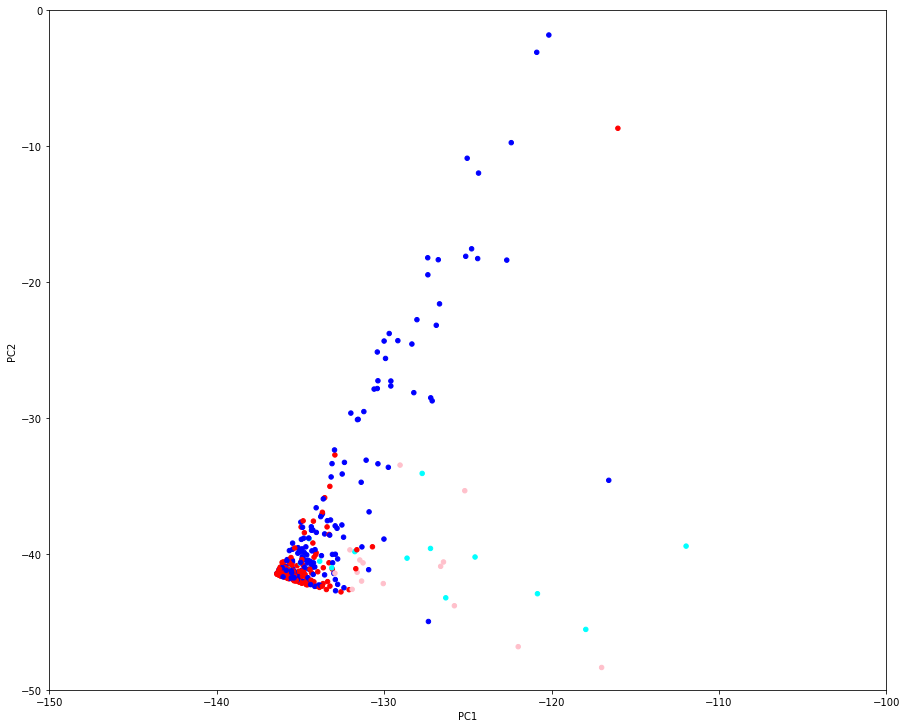

In [10]:
fig, ax = plt.subplots(figsize=(15,12.5))
# plt.xlim([-200, 100])
# plt.ylim([-150, 100])
plt.xlim([-150, -100])
plt.ylim([-50, 0])
pca_df.plot('PC1', 'PC2', kind='scatter', ax=ax, c='color')

In [11]:
pca_df[pca_df['PC1']>100]

,PC1,PC2,color
human_control_10_G19,5369.241881,784.834989,b
human_deletion_31_H17,16695.242182,-746.285595,r
human_deletion_41_K06,6433.819072,537.515949,r
human_deletion_48_K11,1189.290030,3008.932402,r
human_deletion_40_L04,992.798860,2590.149318,r
human_deletion_30_L18,1051.665034,2686.471552,r
human_control_7_M23,882.861582,2331.255392,b
isogenic_deletion_25_O03,946.243159,2638.058461,pink
isogenic_control_23_O15,15657.018077,-674.128487,cyan


# Differentiating features

In [17]:
iso_ctrl = data_by_well[data_by_well.index.str.contains('isogenic_control')]
iso_del = data_by_well[data_by_well.index.str.contains('isogenic_deletion')]
human_ctrl = data_by_well[data_by_well.index.str.contains('human_control')]
human_del = data_by_well[data_by_well.index.str.contains('human_deletion')]

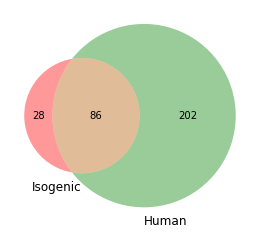

In [36]:
# Find features different between deletion and control in iso and human samples
iso_diff = ttest_2_df(iso_del, iso_ctrl, alpha=0.05, reject_only=True).sort_values(by='adj_p_value', ascending=True)
human_diff = ttest_2_df(human_del, human_ctrl, alpha=0.05, reject_only=True).sort_values(by='adj_p_value', ascending=True)

iso_only = [i for i in iso_diff.index.tolist() if i not in human_diff.index.tolist()]
human_only = [i for i in human_diff.index.tolist() if i not in iso_diff.index.tolist()]
shared = [i for i in iso_diff.index.tolist() if i in human_diff.index.tolist()]

venn2(subsets=(len(iso_only), len(human_only), len(shared)), set_labels=('Isogenic', 'Human'))

In [37]:
iso_diff

,pval,adj_p_value,reject_null
Cytoplasm_Granularity_1_ER,6.423250e-16,2.652802e-13,True
Nuclei_Granularity_2_AGP,1.159843e-10,2.395075e-08,True
Cytoplasm_Intensity_IntegratedIntensityEdge_ER,1.658316e-09,2.282948e-07,True
Cytoplasm_Granularity_1_Mito,7.122030e-09,4.652862e-07,True
Cytoplasm_Correlation_Overlap_DNA_ER,7.886207e-09,4.652862e-07,True
...,...,...,...
Nuclei_Texture_Correlation_RNA_20_03,1.208451e-02,4.537184e-02,True
Cytoplasm_Intensity_MeanIntensityEdge_Mito,1.231184e-02,4.539991e-02,True
Nuclei_Granularity_12_AGP,1.229957e-02,4.539991e-02,True
Cells_Granularity_7_Brightfield,1.330690e-02,4.863496e-02,True


In [38]:
human_diff

,pval,adj_p_value,reject_null
Cells_Correlation_Overlap_DNA_Mito,1.179112e-49,4.869732e-47,True
Cells_Intensity_StdIntensityEdge_ER,1.811828e-42,3.741426e-40,True
Cytoplasm_Intensity_MADIntensity_ER,5.069074e-40,6.978425e-38,True
Cytoplasm_Correlation_Overlap_DNA_RNA,1.210370e-38,1.249707e-36,True
Cytoplasm_RadialDistribution_RadialCV_AGP_1of4,4.374566e-38,3.613392e-36,True
...,...,...,...
Nuclei_Texture_InfoMeas2_RNA_20_01,2.507389e-02,3.646309e-02,True
Cytoplasm_Texture_Correlation_Brightfield_20_00,2.593459e-02,3.758241e-02,True
Nuclei_Texture_DifferenceEntropy_RNA_20_02,2.654847e-02,3.833747e-02,True
Cells_Intensity_IntegratedIntensity_AGP,3.123092e-02,4.494206e-02,True
